In [19]:
import numpy as np
import seaborn as sns
from keras import models, layers, callbacks
from scipy.io import loadmat
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
train_mat = loadmat('data/train_32x32.mat')
test_mat = loadmat('data/test_32x32.mat')

#Format into np array of float pixels and 1d array of ints for labels
train_imgs = np.array(train_mat['X']).astype('float64')
train_lbls = np.array(train_mat['y']).flatten()
test_imgs = np.array(test_mat['X']).astype('float64')
test_lbls = np.array(test_mat['y']).flatten()

#Normalize to 0..1
train_imgs = train_imgs/255.0
test_imgs = test_imgs/255.0

In [3]:
train_imgs = np.moveaxis(train_imgs, -1, 0)
test_imgs = np.moveaxis(test_imgs, -1, 0)

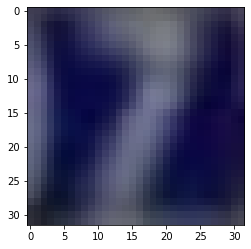

Label:  7


In [4]:
plt.imshow(train_imgs[2241])
plt.show()

print('Label: ', train_lbls[2241])

In [5]:
#Binarize labels
binarizer = LabelBinarizer()
train_lbls = binarizer.fit_transform(train_lbls)
test_lbls = binarizer.fit_transform(test_lbls)

In [6]:
X_trn, X_tst, y_trn, y_tst = train_test_split(train_imgs, train_lbls, test_size=0.2, random_state=0)
print(X_trn.shape, X_tst.shape, y_trn.shape, y_tst.shape)

(58605, 32, 32, 3) (14652, 32, 32, 3) (58605, 10) (14652, 10)


In [7]:
#CNN Model

model = models.Sequential(
    [
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
        layers.Dropout(0.1),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')        
    ]
)

In [21]:
#utility functions
early_stopping = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=8, verbose=1)
red_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)

In [9]:
#Define parameters for applying random transformations to train data
train_datagen = ImageDataGenerator(
    rotation_range=40,
    #width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#Generate batches of transformed image data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_trn,
    target_size=(32, 32),
    batch_size=256,
    shuffle=True,
    class_mode='categorical')

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(X_trn, y_trn, batch_size=50, epochs=30, validation_data=(X_tst, y_tst), callbacks=[early_stopping, red_lr])

Epoch 1/30
1173/1173 [==============================] - 802s 684ms/step - loss: 1.3117 - accuracy: 0.5556 - val_loss: 0.5231 - val_accuracy: 0.8386
Epoch 2/30
1173/1173 [==============================] - 583s 497ms/step - loss: 0.5988 - accuracy: 0.8173 - val_loss: 0.4343 - val_accuracy: 0.8684
Epoch 3/30
1173/1173 [==============================] - 663s 565ms/step - loss: 0.5090 - accuracy: 0.8466 - val_loss: 0.3677 - val_accuracy: 0.8912
Epoch 4/30
1173/1173 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.8635
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1173/1173 [==============================] - 608s 518ms/step - loss: 0.4529 - accuracy: 0.8635 - val_loss: 0.3713 - val_accuracy: 0.8890
Epoch 5/30
1173/1173 [==============================] - 680s 580ms/step - loss: 0.3803 - accuracy: 0.8867 - val_loss: 0.3249 - val_accuracy: 0.9057
Epoch 6/30
1173/1173 [==============================] - 548s 467ms/step - loss: 0.3590 - accu

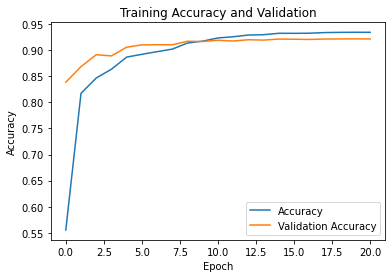

In [12]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

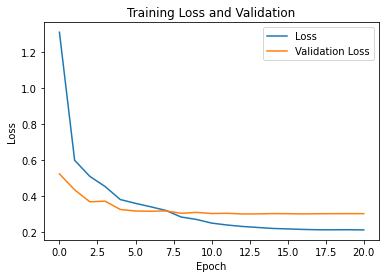

In [13]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(test_imgs, test_lbls, verbose=1)
print('Accuracy: %s, Loss: %s' %(test_accuracy, test_loss))

814/814 [==============================] - 33s 40ms/step - loss: 0.3468 - accuracy: 0.9067
Accuracy: 0.9066917896270752, Loss: 0.3468058109283447


In [17]:
predictions = model.predict_classes(test_imgs)
test_labels = np.argmax(test_lbls, axis=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<AxesSubplot:>

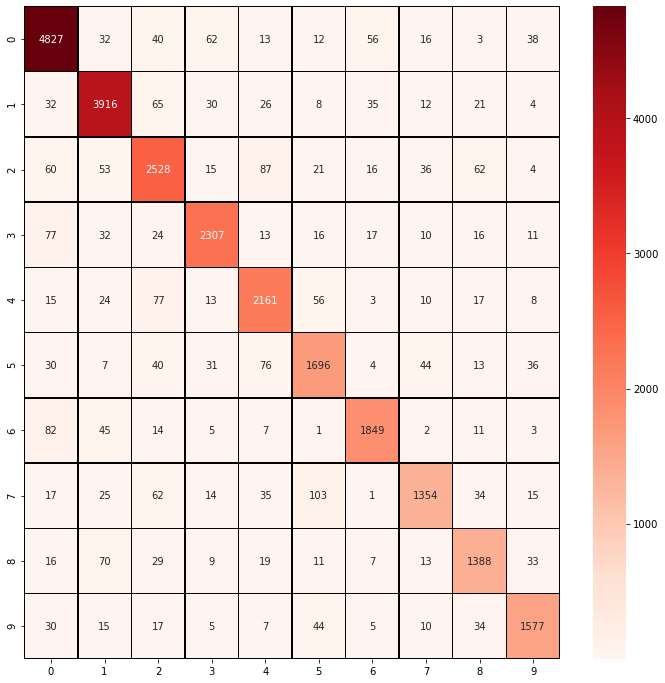

In [20]:
cm = confusion_matrix(test_labels, predictions)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm, cmap='Reds', linewidth=0.5, linecolor='Black', annot=True, fmt="d")